In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mesh import create_2d_circle, create_toy_mesh
from discretization import create_discretization_element, create_discretization_mesh
from solver_bvp import BVP_Poisson_solver, get_n_element_operators
from solver_ivp import AdvectionIVPSolver2D
from scipy.integrate import solve_ivp

from mesh import Mesh
from discretization import DiscretizationElement, DiscretizationMesh
import numpy.typing as npt

import warnings
warnings.filterwarnings('ignore')

In [2]:
x_0, y_0 = -0.75, -0.25
sigma = 0.1

def get_hill_center(
    t: float, *, x_0: npt.NDArray, y_0: npt.NDArray
) -> tuple[npt.NDArray, npt.NDArray]:
    omega = 2 * np.pi
    x_t = x_0 * np.cos(omega * t) + y_0 * np.sin(omega * t)
    y_t = -x_0 * np.sin(omega * t) + y_0 * np.cos(omega * t)
    return x_t, y_t

def u_exact_hill(x, y, t, sigma=sigma):
    x_center_t, y_center_t = get_hill_center(t, x_0=x_0, y_0=y_0)
    return np.exp(-((x - x_center_t) ** 2 + (y - y_center_t) ** 2) / (2 * sigma**2))

def u_exact_hill_dt(x, y, t, x_0=x_0, y_0=y_0, sigma=sigma):
    omega = 2 * np.pi
    xc, yc = get_hill_center(t, x_0=x_0, y_0=y_0)
    xc_t = omega * yc
    yc_t = -omega * xc
    u = u_exact_hill(x, y, t, sigma=sigma)
    return u * ((x - xc) * xc_t + (y - yc) * yc_t) / (sigma**2)

def f_rhs_hill(x: npt.NDArray, y: npt.NDArray, t: float) -> npt.NDArray:
    return np.zeros_like(x)

def advection_velocity_field(x: npt.NDArray, y: npt.NDArray) -> tuple[npt.NDArray, npt.NDArray]:
    return (2 * np.pi * y, -2 * np.pi * x)

In [15]:
V_x = np.array([-1, 1, -1])
V_y = np.array([-1, 1, 1])
EtoV = np.array([[0, 1, 2]])
mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

# V_x = np.array([-1, 1, 1, -1])
# V_y = np.array([-1, -1, 1, 1])
# EtoV = np.array([[1, 2, 4], [2, 3, 4]]) - 1
# mesh_hill_1 = create_toy_mesh(V_x, V_y, EtoV)

N = 5
discretization_element_hill_1 = create_discretization_element(N = N, LocalReorder = np.arange((N+1)*(N+2)//2))
# discretization_element_hill_1 = create_discretization_element(N = N)
discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global
print(f"{x_global.shape = }")

x_global.shape = (21,)


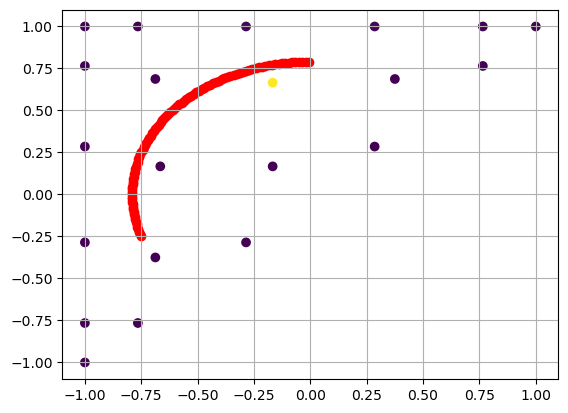

In [19]:
t_max = 0.3
t_array = np.linspace(0, t_max, 100)
x_center_t, y_center_t = get_hill_center(t_array, x_0=x_0, y_0=y_0)

u_true_t = u_exact_hill(x_global, y_global, t=t_array[:, None])
u_0 = u_exact_hill(x_global, y_global, t=0)

plt.scatter(x_global, y_global, c=u_true_t[-1, :], cmap='viridis')
# plt.scatter(x_global, y_global, c=u_0, cmap='viridis')
plt.scatter(x_center_t, y_center_t, color='red')
plt.grid();

In [20]:
ivp_hill_solver_1 = AdvectionIVPSolver2D(
    mesh = mesh_hill_1,
    discretization_element = discretization_element_hill_1,
    discretization_mesh = discretization_mesh_hill_1,
    f_rhs = f_rhs_hill,
    g_bc = u_exact_hill,
    g_bc_dt = u_exact_hill_dt,
    advection_velocity_field = advection_velocity_field
)

dudt = ivp_hill_solver_1.get_rhs_IVP(t=0, u=u_0)
# print(dudt.shape, u_0.shape)

In [22]:
print(t_max)
t0, tf = 0.0, t_max
u_0 = u_exact_hill(x_global, y_global, t=0)
result_scipy = solve_ivp(
    ivp_hill_solver_1.get_rhs_IVP,
    [t0, tf],
    y0 = u_0,
    method = "RK45",
    # max_step = max_step,
    # rtol=rtol,
    # atol=atol
)

0.3


In [23]:
u_N_t = result_scipy.y
print(u_N_t.shape)

t_ivp_solver = result_scipy.t

u_true_ivp_solver = u_exact_hill(x_global, y_global, t=t_ivp_solver[:, None])
u_true_ivp_solver = u_true_ivp_solver.T

err = np.abs(u_true_ivp_solver - u_N_t)
norm_err_t = np.linalg.norm(err, ord = np.inf, axis=0)
norm_err_xy = np.linalg.norm(err, ord = np.inf, axis=1)
print(f"{err.shape = }")

(21, 11)
err.shape = (21, 11)


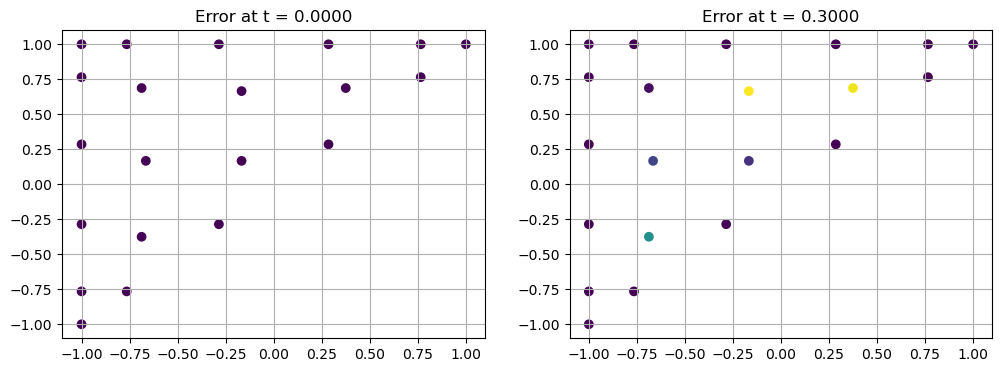

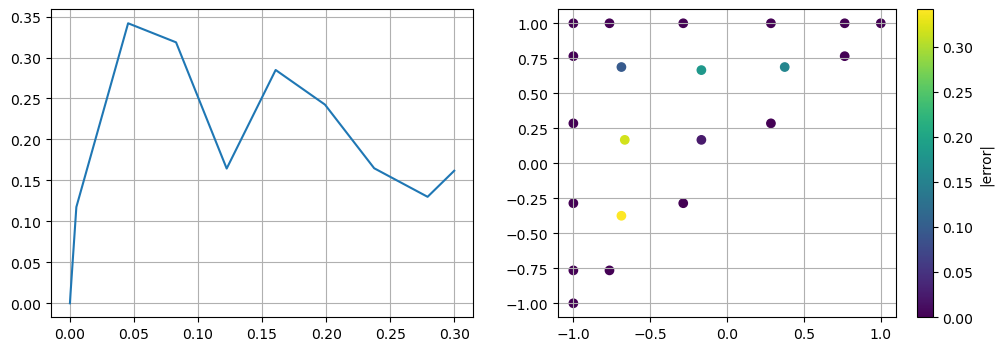

In [24]:
t_test_1, t_test_2 = 0, 10

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].scatter(x_global, y_global, c = err[:, t_test_1])
ax[0].set_title(f"Error at t = {t_ivp_solver[t_test_1]:.4f}")
ax[0].grid();
ax[1].scatter(x_global, y_global, c = err[:, t_test_2])
ax[1].set_title(f"Error at t = {t_ivp_solver[t_test_2]:.4f}")
ax[1].grid();

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_ivp_solver, norm_err_t)
ax[0].grid();
sc = ax[1].scatter(x_global, y_global, c = norm_err_xy)
fig.colorbar(sc, ax=ax[1], label='|error|')
ax[1].grid();

In [25]:
energy_array = np.zeros(t_ivp_solver.shape[0])
for t in range(t_ivp_solver.shape[0]):
    energy_array[t] = 0.5 * u_N_t[:, t].T @ ivp_hill_solver_1.M_global @ u_N_t[:, t]

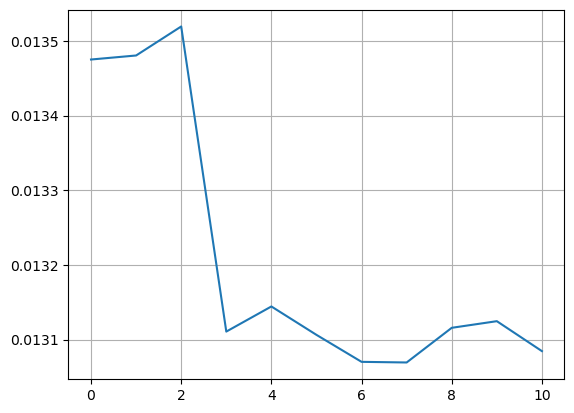

In [26]:
plt.plot(energy_array)
plt.grid();

In [27]:
def solve_ivp_convergence(N, t_max = 1):
    
    discretization_element_hill_1 = create_discretization_element(N = N)
    discretization_mesh_hill_1 = create_discretization_mesh(mesh = mesh_hill_1, discretization_element = discretization_element_hill_1)

    # r, s = discretization_element_hill_1.r, discretization_element_hill_1.s
    x_global, y_global = discretization_mesh_hill_1.x_global, discretization_mesh_hill_1.y_global

    ivp_hill_solver_1 = AdvectionIVPSolver2D(
        mesh = mesh_hill_1,
        discretization_element = discretization_element_hill_1,
        discretization_mesh = discretization_mesh_hill_1,
        f_rhs = f_rhs_hill,
        g_bc = u_exact_hill,
        g_bc_dt = u_exact_hill_dt,
        advection_velocity_field = advection_velocity_field
    )

    u_0 = u_exact_hill(x_global, y_global, t=0)
    result_scipy = solve_ivp(
        ivp_hill_solver_1.get_rhs_IVP,
        [t0, t_max],
        y0 = u_0,
        method = "RK45",
        # max_step = max_step,
        # rtol=rtol,
        # atol=atol
    )

    u_t_max = u_exact_hill(x_global, y_global, t=0)
    u_num_t_max = result_scipy.y[:, -1]
    err_t_max = np.abs(u_t_max - u_num_t_max)

    error_inf_norm = np.linalg.norm(err_t_max, ord = np.inf)

    return error_inf_norm

In [28]:
N_array = np.arange(5, 25)
error_array = np.zeros(N_array.shape[0])

for i, N in enumerate(tqdm(N_array)):
    error_array[i] = solve_ivp_convergence(N, t_max = 1)

100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


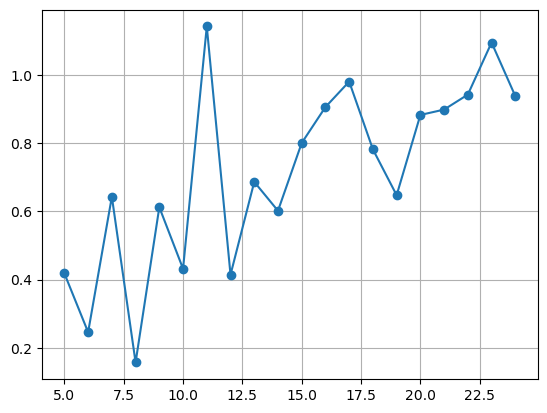

In [29]:
plt.plot(N_array, error_array, marker='o')
plt.grid();